In [28]:
%matplotlib inline

# Train an RBM to approximate a quantum state
With RBM as a state ansatz, we need to train its parameters in order to make it close to the ground state wave function of a hamiltonian.

Notice that the cost function now is energy rather than a known dataset, we use Markov chain Monte Carlo (MCMC) method to extract the energy expectation value and gradient.

In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import binning_statistics
from rbm_tf_cd import load_demo_rbm

A model is a problem definiton, it contains state ansatz, hamiltonian, optimizer and computation graphs for wave function and gradient. Training a model using gradients requires expectation values for at least three operators, $H$, $\frac{\partial}{\partial \Theta}$ and $H\frac{\partial}{\partial \Theta}$.

In [2]:
def train(model, max_iter=2000):
    '''train a model.'''
    E_list, E_err_list = [], []
    for i in range(max_iter):
        E_mean, grad_mean, Egrad_mean, E_err = vmc_measure(
            model, initial_config=np.array([0,1]*(model.nsite//2)), num_sample=1000)
        print('Step %d, dE = %.4f' % (i, E_mean - model.E_exact))
        model.update_vars(E_mean, grad_mean, Egrad_mean)
        E_list.append(E_mean)
        E_err_list.append(E_err)
        plt.cla()
        plt.errorbar(np.arange(1,i+2), E_list, yerr=E_err_list)
        plt.axhline(model.E_exact, ls='--', color='#999999')
        plt.show()
    return E_list, E_err_list

The above required expectation values can be approximated by emsemble average of following operators over generated samples in VMC run, $\langle E_{\rm loc}\rangle$, $\langle\Delta_{\rm loc}\rangle$ and $\langle E_{\rm loc}\Delta_{\rm loc}\rangle$, with $E_{\rm loc}=\frac{\langle\psi|H|\sigma\rangle}{\langle\sigma|\psi\rangle}$ and $\Delta_{\rm loc}=\frac{\partial\log\langle\sigma|\psi\rangle}{\partial \Theta}$.

VMC requires a model with following property
* can propose a new configuration, given old configuration.
* can give the wave function amplitude on a spin configuration $\langle\sigma|\psi\rangle$.
* given configuration, being able to provide local quantities $E_{\rm loc}$ and $\Delta_{\rm loc}$.

As a result, VMC measurements give us desired expectation values and and error estimation for energy.

In [3]:
def vmc_measure(model, initial_config, num_bath=200, num_sample=1000, num_bin=50, measure_step=None):
    '''
    Measure an operator.

    Args:
        model (Model): model definition.
        num_sample (int): number of samples.

    Return:
        number,
    '''
    if measure_step is None:
        measure_step = len(initial_config)
    print_step = num_sample * measure_step / 5

    E_locs, grad_locs = [], []
    config = initial_config
    wf = model.get_wf(config)

    n_accepted = 0
    for i in range(num_bath + num_sample * measure_step):
        # generate new config and calculate probability ratio
        config_proposed = propose_config(config)
        wf_proposed = model.get_wf(config_proposed)
        prob_ratio = np.abs(wf_proposed / wf).item()**2

        # accept/reject move by one-line metropolis algorithm
        if np.random.random() < prob_ratio:
            config = config_proposed
            wf = wf_proposed
            n_accepted += 1

        # measurements
        if i >= num_bath and i % measure_step == 0:
            # here, I choose a lazy way that re-compute on this config, in order to get its gradients easily.
            E_loc, grad_loc = model.local_measure(config)
            E_locs.append(E_loc)
            grad_locs.append(grad_loc)

        # print status
        if i % print_step == print_step - 1:
            print('%-10s Accept rate: %.3f' %
                  (i + 1, n_accepted * 1. / print_step))
            n_accepted = 0

    # process samples
    E_locs = np.array(E_locs)
    E_mean, E_err = binning_statistics(E_locs, num_bin=num_bin)

    grad_mean = []
    Egrad_mean = []
    gradgrad_mean = []
    for grad_locs_i in zip(*grad_locs):
        grad_locs_i = np.array(grad_locs_i)
        grad_mean.append(grad_locs_i.mean(axis=0))
        Egrad_mean.append(
            (E_locs[(slice(None),) + (None,) * (grad_locs_i.ndim - 1)] * grad_locs_i).mean(axis=0))
    return E_mean, grad_mean, Egrad_mean, E_err

Model definition.

In [4]:
class Model(object):
    def __init__(self, J, rbm, sess, E_exact, learning_rate=0.01, use_cnn=True):
        self.J = J
        self.sess = sess
        self.nsite = rbm.visible_input.get_shape()[1].value
        self.rbm = rbm
        self.learning_rate = learning_rate
        # self.optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        self.E_exact = E_exact

        # build graphs
        if use_cnn:
            self.wf_graph = rbm.build_graph('psi-cnn')
            self.var_list = [rbm.weights, rbm.hidden_bias]
        else:
            self.wf_graph = rbm.build_graph('psi')
            self.var_list = [rbm.weights, rbm.hidden_bias, rbm.visible_bias]
        self.gradients = tf.gradients(
            xs=self.var_list, ys=tf.log(self.wf_graph))

    def get_wf(self, config):
        wf = self.sess.run(self.wf_graph, feed_dict={
                           self.rbm.visible_input: config[None, :]})
        return wf

    def local_measure(self, config):
        '''get E_loc, grad_loc.'''
        # {d/dW}_{loc}
        res = self.sess.run([self.wf_graph] + self.gradients,
                            feed_dict={self.rbm.visible_input: config[None, :]})
        wf = res[0]
        grad_locs = res[1:]

        # E_{loc}
        E_loc = heisenberg_loc(self.J, config, self.get_wf, wf).item()

        return E_loc, grad_locs

    def update_vars(self, E_mean, grad_mean, Egrad_mean):
        g_list = [eg - E_mean * g for eg,
                  g in zip(Egrad_mean, grad_mean)]  # no conjugate here
        # assign new values
        assign_ops = [var.assign(var - self.learning_rate * g)
                      for var, g in zip(self.var_list, g_list)]
        #assign_ops = self.optimizer.apply_gradients(zip(g_list, self.var_list))
        self.sess.run(assign_ops)

Take ~ 5% probability to flip all spin, can making VMC sample better in Heisenberg model, proposed configuration satisfies spin conservation.

In [5]:
def propose_config(old_config, prob_flip=0.05):
    '''
    flip two positions as suggested spin flips.
    '''
    if np.random.random() < prob_flip:
        return 1-old_config

    nsite = len(old_config)
    upmask = old_config == 0
    flips = np.random.randint(0, nsite // 2, 2)
    iflip0 = np.where(upmask)[0][flips[0]]
    iflip1 = np.where(~upmask)[0][flips[1]]

    config = old_config.copy()
    config[iflip0] = 1
    config[iflip1] = 0
    return config

Calculate local energy

In [6]:
def heisenberg_loc(J, config, wave_func, wf0):
    '''
    1D Periodic Heisenberg chain local energy.
    '''
    # get weights and flips after applying hamiltonian \sum_i w_i|sigma_i> = H|sigma>
    nsite = len(config)
    wl, flips = [], []
    # J*SzSz terms.
    nn_par = 1 - 2. * (np.roll(config, -1) ^ config)
    wl.append(J / 4. * (nn_par).sum(axis=-1))
    flips.append(np.array([], dtype='int64'))

    # J*SxSx and J*SySy terms.
    mask = nn_par != 1
    i = np.where(mask)[0]
    j = (i + 1) % nsite
    wl += [-J / 2.] * len(i)
    flips.extend(zip(i, j))

    # calculate local energy <psi|H|sigma>/<psi|sigma>
    acc = 0
    for wi, flip in zip(wl, flips):
        config_i = config.copy()
        config_i[list(flip)] = 1 - config_i[list(flip)]
        eng_i = wi * wave_func(config_i) / wf0
        acc += eng_i
    return acc

Finally, defined and run a optimization within a tensorflow session.

In [7]:
def run_demo():
    tf.set_random_seed(10087)
    np.random.seed(10086)
    rbm = load_demo_rbm('spin-chain')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        model = Model(J=1.0, rbm=rbm, sess=sess, E_exact=-
                      3.65109341, learning_rate=0.01)
        E_list, E_err_list = train(model, max_iter=200)
    plt.errorbar(arange(1, len(E_list) + 1), E_list, yerr=E_err_list)

1600       Accept rate: 0.949
3200       Accept rate: 0.958
4800       Accept rate: 0.960
6400       Accept rate: 0.951
8000       Accept rate: 0.956
Binning Statistics: Energy = -2.6651 +- 0.0432, Auto correlation Time = 0.5010
Step 0, dE = 0.9860


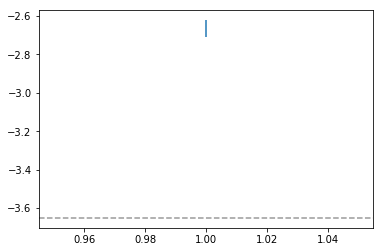

1600       Accept rate: 0.958
3200       Accept rate: 0.950
4800       Accept rate: 0.951
6400       Accept rate: 0.946
8000       Accept rate: 0.951
Binning Statistics: Energy = -2.6228 +- 0.0417, Auto correlation Time = 0.4512
Step 1, dE = 1.0283


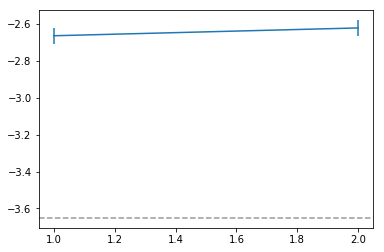

1600       Accept rate: 0.955
3200       Accept rate: 0.939
4800       Accept rate: 0.949
6400       Accept rate: 0.951
8000       Accept rate: 0.954
Binning Statistics: Energy = -2.6270 +- 0.0451, Auto correlation Time = 0.5291
Step 2, dE = 1.0241


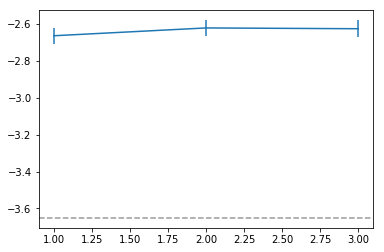

1600       Accept rate: 0.953
3200       Accept rate: 0.954
4800       Accept rate: 0.942
6400       Accept rate: 0.954
8000       Accept rate: 0.963
Binning Statistics: Energy = -2.6405 +- 0.0422, Auto correlation Time = 0.4835
Step 3, dE = 1.0106


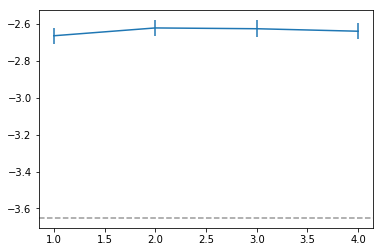

1600       Accept rate: 0.958
3200       Accept rate: 0.958
4800       Accept rate: 0.951
6400       Accept rate: 0.964
8000       Accept rate: 0.953
Binning Statistics: Energy = -2.5787 +- 0.0367, Auto correlation Time = 0.3609
Step 4, dE = 1.0724


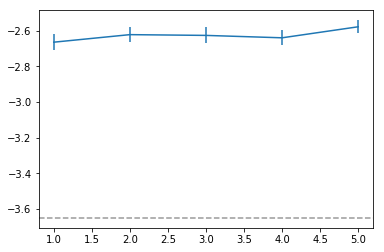

1600       Accept rate: 0.950
3200       Accept rate: 0.948
4800       Accept rate: 0.953


KeyboardInterrupt: 

In [8]:
run_demo()